# THAILAND 1960-2000

Group Ma Yinchu 

In [1]:
!pip install wbdata
!pip install cufflinks
!pip install gspread-pandas
!pip install plotly 

import plotly as plotly
import wbdata as wb
import pandas as pd
import numpy as np
import cufflinks as cf
import gspread_pandas as gsp

  Using cached wbdata-0.3.0-py3-none-any.whl (14 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.6.2 requires h5py~=3.1.0, but you'll have h5py 3.3.0 which is incompatible.
tensorflow 2.6.2 requires numpy~=1.19.2, but you'll have numpy 1.21.5 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you'll have typing-extensions 4.1.1 which is incompatible.
fancyimpute 0.6.0 requires keras==2.4.3, but you'll have keras 2

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



**[#A] Population Statistics Function** 
A python function named population
that will deliver information to
answer the queries of the following
form:

In [year] how many
[people/males/females] aged [low] to
[high] were living in [the
world/region/country]?

In [2]:
def population_interpolated(year, sex, age_range, place, summary=False):
    '''
    Returns an integer specifying the total population of a given age range, male or female, 
    in a given year and place.  When the age bins specified are not the age bins 
    given by wbdata, populations are interpolated to create estimates for the age bins. 
    Although there is data for ages above 99 in wbdata, it is excluded to reduce the complexity of the function. 
    
            Parameters:
                    year (int): Year to get population totals from. 
                    sex (str): 'male' or 'female'  
                    age_range (tuple of ints): Age range slice. Can be the same year e.g. (2,2)
                                to get a single age. Must be between 0 and 99, inclusive. 
                        
                    place(str): Country code from wbdata, e.g. 'THA' or 'IND'
                    summary 

            Returns:
                    Integer of total population for a sex, age_range, and year   
    '''
    assert sex in ['male', 'female'], "sex must be 'male' or 'female'"
    assert 1960 < year < 2021, "Year must be between 1960 and 2021 (inclusive)"
    assert type(age_range) == tuple
    assert age_range[0] in range(0,100), "Age range must be between 0 and 99 (inclusive)"
    assert age_range[1] in range(0,100), "Age range must be between 0 and 99 (inclusive)"
    assert age_range[1] >= age_range[0], "The second age value must be higher or equal to the first"
    assert summary in [True, False], "summary must be True or False"
    
    # Convert sex variable to use in regex
    if sex == 'female':
        sex_re = 'FE'
    else:
        sex_re = 'MA'
    
    # Select only relevant indicators 
    indicator_40_df = pd.DataFrame(wb.get_indicator(source='40', cache=False))
    gender_bins = indicator_40_df[indicator_40_df['id'].str.fullmatch('SP.POP.*.' + sex_re)]
    indicator_dict = dict(zip(gender_bins.id, gender_bins.name))
    
    # Select a range of specified age bins 
    start = int(np.floor(age_range[0]/5))
    stop = int(np.floor(age_range[1]/5))
    gender_slice = dict(list(indicator_dict.items())[start:stop+1])

    # Generate DataFrame using only specified age range 
    year = pd.to_datetime(year, format='%Y')
    df = wb.get_dataframe(
        indicators=gender_slice, 
        country=place, 
        data_date = year, 
        cache=False,
        keep_levels=True)
    
    # Scale populatin bins according to the given age range
    # If an age range is given that doesn't match the predetermined bins, it is scaled to create an estimate.
    # For example, a valid bin is 0-4. If we want to get population estimates for only ages 2-4, then we simply 
    # take 3/4, or 75%, of the data from that bin. 
    
    # Edge case: if selecting range from a single bin, just calculate a fraction of the bin
    if len(df.columns) == 1: 
        end_scale = 1 
        if age_range[0] and age_range[1] > 79:
            start_scale = (age_range[1] - age_range[0] + 1) / 20
        else:
            start_scale = (age_range[1] - age_range[0] + 1) / 5
    
    # Edge case: if end range is in 80UP but start range is not 
    elif age_range[1] > 79: 
        start_scale = (5 - (age_range[0] % 5)) / 5
        end_scale = ((age_range[1] % 20) + 1) / 2
        
    # All other possible slices 
    else:
        start_scale = (5 - (age_range[0] % 5)) / 5
        end_scale = ((age_range[1] % 5) + 1) / 5 
    
    # Scale first and last bin
    df.iloc[:,0] = df.iloc[:,0] * start_scale 
    df.iloc[:, -1] = df.iloc[:, -1] * end_scale
    
    pop_sum = df.sum(axis=1)[0]
    
    if summary == True:
        return (f'In {year.year}, approximately {pop_sum} {sex}s'
               f' aged {age_range[0]} to {age_range[1]} were living in {place}'
       )
    else:
        return pop_sum

In [3]:
 population_interpolated(1990, 'female', (0,2), 'THA')

1573728.0

In [4]:
 population_interpolated(2000, 'male', (12,33), 'THA')

11956903.8

In [9]:
# Example Errors
population_interpolated(1990, 'mal', (0,2), 'THA')

AssertionError: sex must be 'male' or 'female'

**[#A] Population DataFrames** 

A function that returns a pandas DataFrame
indexed by Region or Country and Year, with
columns giving counts of people in different
age-sex groups.

In [5]:
def pop_df(start_year=1960, end_year=2021, country='all'):
    '''
    Returns pandas DataFrame of male and female population counts 
    in age bins from wbdata, indexed by country and year. 
    
            Parameters:
                    start_year (int): First year of the year range (inclusive)
                    end_year (int): End year of the year range (inclusive)
                    country (list): Country or list of countries to return. 
                                    Returns all countries if not specified.

            Returns:
                    df (pandas DataFrame): pandas DataFrame 
    '''
    # Select only relevant indicators
    indicator_40_df = pd.DataFrame(wb.get_indicator(source='40', cache=False))
    gender_bins = indicator_40_df[indicator_40_df['id'].str.fullmatch('SP.POP.*.(FE|MA)')]
    indicator_dict = dict(zip(gender_bins.id, gender_bins.name))
    
    # Construct dataframe with wbdata.get_dataframe() 
    start_year = pd.to_datetime(start_year, format='%Y')
    end_year = pd.to_datetime(end_year, format='%Y')
    df = wb.get_dataframe(
        indicators=indicator_dict, 
        country=country, 
        data_date = (start_year, end_year), 
        cache=False,
        keep_levels=True) 
    df = df.rename_axis(index=['country', 'year'])
    return df 

In [7]:
# Test: Populations from Thailand, Vietnam, and India from 1960-2001
tha_vnm_ind = pop_df(country = ['THA'], start_year=1960, end_year=2001)
tha_vnm_ind

Population ages 00-04, female  Population ages 00-04, male  \
country  year                                                               
Thailand 2001                      2226953.0                    2355033.0   
         2000                      2281245.0                    2412779.0   
         1999                      2332574.0                    2464916.0   
         1998                      2385913.0                    2518709.0   
         1997                      2435971.0                    2567846.0   
         1996                      2476362.0                    2603928.0   
         1995                      2503412.0                    2621863.0   
         1994                      2530546.0                    2646857.0   
         1993                      2556550.0                    2667130.0   
         1992                      2581035.0                    2685278.0   
         1991                      2603691.0                    2705784.0   
         1990                      2622880.0                    2730069.0   
         1989                      2661016.0                    2766476.0   
         1988                      2698827.0                    2807933.0   
         1987                      2735728.0                    2850590.0   
         1986                      2772809.0                    2890407.0   
         1985                      2810956.0                    2925125.0   
         1984                      2852514.0                    2966852.0   
         1983                      2898714.0                    3009723.0   
         1982                      2945532.0                    3052254.0   
         1981                      2987723.0                    3092952.0   
         1980                      3024015.0                    3132804.0   
         1979                      3052021.0                    3165312.0   
         1978                      3070062.0                    3188546.0   
         1977                      3085646.0                    3209255.0   
         1976                      3108278.0                    3235516.0   
         1975                      3141545.0                    3270242.0   
         1974                      3155818.0                    3285079.0   
         1973                      3169698.0                    3297699.0   
         1972                      3173101.0                    3298762.0   
         1971                      3152085.0                    3275271.0   
         1970                      3097675.0                    3218755.0   
         1969                      3044019.0                    3161203.0   
         1968                      2977326.0                    3090187.0   
         1967                      2900797.0                    3008935.0   
         1966                      2820992.0                    2923754.0   
         1965                      2740894.0                    2837496.0   
         1964                      2664197.0                    2754748.0   
         1963                      2592263.0                    2676604.0   
         1962                      2520239.0                    2598529.0   
         1961                      2441847.0                    2514905.0   
         1960                      2354011.0                    2422763.0   

               Population ages 05-09, female  Population ages 05-09, male  \
country  year                                                               
Thailand 2001                      2460746.0                    2575952.0   
         2000                      2493524.0                    2608519.0   
         1999                      2520335.0                    2630954.0   
         1998                      2538032.0                    2644882.0   
         1997                      2554397.0                    2658681.0   
         1996                      2577117.0                    2679435.0   
         1

**[#B] Population Pyramids**

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, and constructs a
“population pyramid” graph for
visualizing the data.


In [9]:
def PopulationPyramid(pop_data, country, year):
    '''
    Adapted from Population Lecture 1

    Description: Constructs a "population pyramid" graph to visualize population data

    Parameters: 
        pop_data: dataframe with columns providing counts of people by age-sex groups
        country: country of interest (string)
        year: year of interest (integer)
    '''
    
    # Import everything
    import plotly.offline as py
    import plotly.graph_objs as go
    import pandas as pd
    import numpy as np

    # Initialize notebook 
    py.init_notebook_mode(connected=True)
    
    # We construct a list of age ranges
    # Ranges top out at 80, and go in five year increments
    age_ranges = np.arange(1,82,5)
    
    # Plot the counts of age ranges for specified year
    # May have to change based on the names of columns in pop_data
    layout = go.Layout(barmode='overlay',
        yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
        xaxis=go.layout.XAxis(title='Number'))
    
    bins = [go.Bar(x = pop_data.loc[country, str(year),:].filter(regex=" male").values[0],
        y=age_ranges,
        orientation='h',
        name='Men',
        marker=dict(color='purple'),
        hoverinfo='skip'
        ),
            
    go.Bar(x = -pop_data.loc[country, str(year),:].filter(regex=" female").values[0],
        y=age_ranges,
        orientation='h',
        name='Women',
        marker=dict(color='pink'),
        hoverinfo='skip',
        )
    ]
    
    py.iplot(dict(data=bins, layout=layout))

In [10]:
# Test: Populations from Thailand in 1990
my_pop = pop_df(country = ['THA'], start_year=1960, end_year=2001)
PopulationPyramid(my_pop, 'Thailand', 1990)

**[#C] Animated Population Pyramids**

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, with rows
corresponding to different years, and
constructs an animated “population
pyramid” graph for visualizing how the
population changes over time.

In [12]:
def AnimatedPyramid(pop_data, country, start_year, end_year):
    '''
    Adapted from Population Lecture 1

    Description: Constructs an "animated population pyramid" graph to visualize population data
        overtime, within a specified range of years (inclusive)

    Parameters: 
        pop_data: dataframe with columns providing counts of people by age-sex groups
        country: country of interest (string)
        start_year: starting year (integer)
        end_year: ending year (integer)
    '''
    
    # Import everything
    import plotly.offline as py
    import plotly.graph_objs as go
    import pandas as pd
    import numpy as np
    from ipywidgets import interactive, HBox, VBox

    # Initialize notebook 
    py.init_notebook_mode(connected=True)
    
    # We construct a list of age ranges
    # Ranges top out at 80, and go in five year increments
    age_ranges = np.arange(1,82,5)
    
    # Define the range of years
    years = np.arange(start_year, end_year+1)
    
    # Plot the counts of age ranges for specified year    
    bins = [go.Bar(x = pop_data.loc[country, str(start_year),:].filter(regex=" male").values[0],
        y=age_ranges,
        orientation='h',
        name='Men',
        marker=dict(color='purple'),
        hoverinfo='skip'
        ),
            
    go.Bar(x = -pop_data.loc[country, str(start_year),:].filter(regex=" female").values[0],
        y=age_ranges,
        orientation='h',
        name='Women',
        marker=dict(color='pink'),
        hoverinfo='skip',
        )
    ]
    
    layout = go.Layout(barmode='overlay',
        yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
        xaxis=go.layout.XAxis(title='Number'))
    
    f = go.FigureWidget(data=bins,layout=layout)
        
    def update_count(year): # y = current year.
        f.data[0].x = pop_data.loc[country, str(year),:].filter(regex=" male").values[0]
        f.data[1].x = -pop_data.loc[country, str(year),:].filter(regex=" female").values[0]
        f.data[0].y = age_ranges
        f.data[1].y = age_ranges

    year_slider = interactive(update_count,year=(start_year,end_year,1))
    vb = VBox((f, year_slider))
    vb.layout.align_items = 'center'
    return vb

In [13]:
# Populations from Thailand in 1960-2000
my_pop = pop_df(country = ['THA'], start_year=1960, end_year=2001)
AnimatedPyramid(my_pop, 'Thailand', 1960, 2000)

    'data': [{'hoverinfo': 'skip',
              'marker': {'color': 'purple'},
…

**[#C] Agricultural Supply** 

Relate changes in agricultural food supply
to changes in population.

In [15]:
!pip install eep153_tools
!pip install python_gnupg

#from eep153_tools.sheets import decrypt_credentials
#decrypt_credentials('../students.json.gpg')
# Only have to run this code once 

  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.4.8-py2.py3-none-any.whl (18 kB)


In [16]:
!ls ~/.eep153.service_accounts/

students@eep153.iam.gserviceaccount.com


In [17]:
from eep153_tools.sheets import read_sheets

#### Read a bunch of google worksheets into a dictionary of dataframes
data = read_sheets('https://docs.google.com/spreadsheets/d/1DLn9owcS7ggojJGWlI9vKSz0hqozn6cbcqNGWgzMZ8k',force_numeric=False)

data.keys()

#data['Output'].head() As a check 

Key available for students@eep153.iam.gserviceaccount.com.


dict_keys(['Explanation', 'Ag TFP', 'Output', 'Inputs', 'Factor Shares', 'Ag Land', 'Land Weights', 'Cropland', 'Irrig', 'Pasture', 'Labor', 'Livestock', 'Machinery', 'Fertilizer', 'Feed'])

In [18]:
import pandas as pd

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

df = pd.DataFrame(D)
df

Output  Ag TFP  Ag Land  Irrig  Pasture   Labor  Livestock  \
WDI Code Year                                                                  
         1961   441067.0   111.0    184.0    4.0     56.0    31.0      263.0   
         1962   449727.0   113.0    184.0    4.0     56.0    30.0      252.0   
         1963   455937.0   111.0    189.0    4.0     54.0    30.0      259.0   
         1964   441651.0   108.0    187.0    4.0     59.0    30.0      253.0   
         1965   484620.0   121.0    188.0    5.0     61.0    29.0      246.0   
...                  ...     ...      ...    ...      ...     ...        ...   
ZWE      2015  1419365.0    97.0   2460.0  175.0  12100.0  4877.0     5278.0   
         2016  1515900.0    91.0   2966.0  175.0  12100.0  5023.0     5931.0   
         2017        NaN     NaN      NaN    NaN      NaN  5169.0        NaN   
         2018        NaN     NaN      NaN    NaN      NaN  5330.0        NaN   
         2019        NaN     NaN      NaN    NaN      NaN  5499.0        NaN   

               Machinery  Fertilizer       Feed  
WDI Code Year                                    
         1961     1692.0      2358.0   134016.0  
         1962     1740.0      2496.0   132329.0  
         1963     1890.0      2814.0   157105.0  
         1964     1976.0      3327.0   159653.0  
         1965     1679.0      3537.0   140357.0  
...                  ...         ...        ...  
ZWE      2015    31350.0     91600.0  1318934.0  
         2016    32911.0    130000.0  1501953.0  
         2017        NaN         NaN        NaN  
         2018        NaN         NaN        NaN  
         2019        NaN         NaN        NaN  

[10974 rows x 10 columns]

In [19]:
# Graph for all countries Ag. 
cf.go_offline()

df['Output'].unstack().T.iplot(title="Value of Agricultural Output",
                               yTitle='Thousands of 2005-06 Dollars',
                               xTitle='Year')

#double click THA for Thailand's data 

In [20]:
thailand = df.xs('THA',level='WDI Code').replace(0,np.nan).dropna(how='any')

# Put in log differences
dthailand = np.log(thailand).diff()
dthailand['Inputs'] = dthailand['Output'] - dthailand['Ag TFP']

dthailand.mean()


Output        0.029300
Ag TFP        0.015159
Ag Land       0.015397
Irrig         0.025011
Pasture       0.020435
Labor         0.003218
Livestock     0.000508
Machinery     0.075138
Fertilizer    0.085982
Feed          0.049078
Inputs        0.014142
dtype: float64

In [21]:
dthailand[['Output','Inputs','Ag TFP']].iplot(title="Growth rates of output, inputs, & TFP",
                                           xTitle="Year")

**[#C] Population Maps**

A Jupyter notebook which queries a
population database and provides
visualizations in the form of maps.
An example of a library that may be
useful is geopandas.

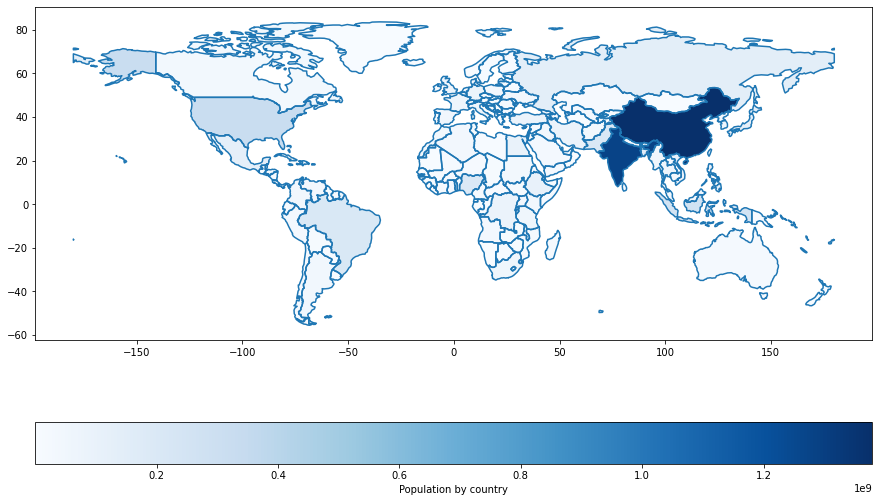

In [23]:
def MapWorldPopulation():
    import geopandas
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]

    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax)
    world.plot(column='pop_est', ax=ax, legend=True, cmap='Blues',
               legend_kwds={'label': "Population by country", 'orientation': "horizontal"});

MapWorldPopulation()

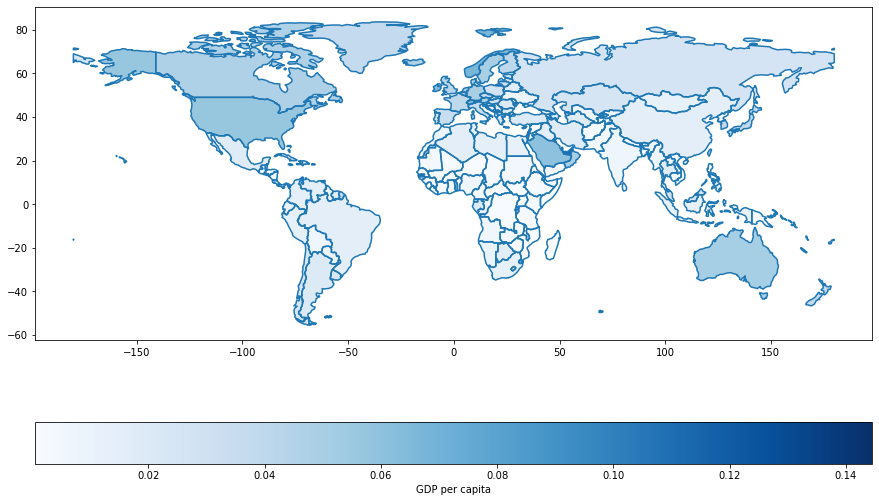

In [24]:
def MapWorldGDP():
    import geopandas
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]
    world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax)
    world.plot(column='gdp_per_cap', ax=ax, legend=True, cmap='Blues', figsize=(15, 10),
               legend_kwds={'label': "GDP per capita", 'orientation': "horizontal"});
    
MapWorldGDP()